In [1]:
%%capture --no-display

!pip install pandas scikit-learn seaborn nltk wordcloud

In [31]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import wordnet

In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/guillaume/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Impose a seed for reproducibility
random_seed = 421

In [5]:
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    shuffle=True,
    random_state=random_seed,
    categories=['sci.electronics', 'talk.religion.misc', 'rec.sport.baseball', 'comp.sys.ibm.pc.hardware', 'sci.med'],
)

In [6]:
# Create a DataFrame from the dataset
df = pd.DataFrame({'text': dataset.data, 'label': dataset.target})

# Map target labels to target names
df['label'] = df['label'].map(lambda x: dataset.target_names[x])


from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
df['label_indices'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label,label_indices
0,"This may sound like a simple-minded question, ...",sci.electronics,2
1,: I have notice a lot of electronics questions...,sci.electronics,2
2,\n[deleted]\n\n\nKeep in mind this was in Mass...,rec.sport.baseball,1
3,"\nUndoubtedly it does, to maintain such a weig...",sci.med,3
4,\nI am hoping to produce the first update of t...,rec.sport.baseball,1


In [7]:
unique_labels = np.unique(df['label'])
number_of_unique_labels = len(unique_labels)
number_of_samples = len(df['text'])
print('There are {} different labels that describe a total of {} documents.'.format(
    number_of_unique_labels, number_of_samples))

There are 5 different labels that describe a total of 4578 documents.


The 20 different labels are the following. We note that the distribution is not uniform, there is a class imbalance.
**TODO**

0: comp.sys.ibm.pc.hardware
1: rec.sport.baseball
2: sci.electronics
3: sci.med
4: talk.religion.misc


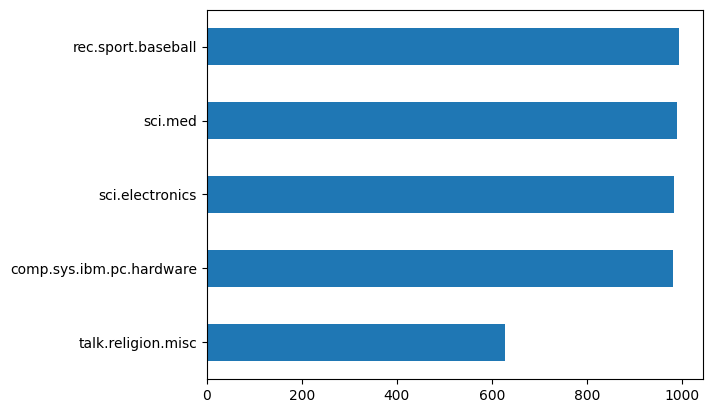

In [8]:
for label_index in range(number_of_unique_labels):
    print('{}: {}'.format(label_index, unique_labels[label_index]))
    
df.label.value_counts().plot.barh()
plt.gca().invert_yaxis()

Below we provide an example of samples taken from three different labels:

In [9]:
print('First example: sample number {} (label: {})\n\n{}\n'.format(
    200, df.label[200], df.text[200]))
print('-' * 64)
print('Second example: sample number {} (label: {})\n\n{}\n'.format(
    1000, df.label[1000], df.text[1000]))
print('-' * 64)
print('Third example: sample number {} (label: {})\n\n{}\n'.format(
    4444, df.label[4444], df.text[4444]))

First example: sample number 200 (label: comp.sys.ibm.pc.hardware)

I know this is the wrong newsgroup, but I was wondering if anyone 
knows the date(s) of this year's COMDEX convention in Atlanta,GA.
Or has it passed already?? E-mail if possible. Thanks.


----------------------------------------------------------------
Second example: sample number 1000 (label: rec.sport.baseball)


[...]

The events I saw were:
1)  Called strike by Hirschbeck
2)  Shocked-looking Gant asks for appeal to first
3)  No appeal to first
4)  Gant steps out of batters box.
5)  Hirschbeck *immediately* orders Gant back in.  [bad move]
6)  Gant ignores Hirschbeck and walks off. [bad move]
7)  Hirschbeck yells at Gant.  Gant is silent.
8)  Hirschbeck calls for the pitch.
9)  Pitch is called a strike.
10)  Cox argues (couldn't see when he came on the field)
11)  Cox is ejected, players everywhere
12)  Play finally resumes.

Gant shouldn't have ignored Hirschbeck.  Not returning made the strike
call fairly likel

### Systematic cleaning

In [10]:
# TODO Tokenise, remove double white spaces

In [11]:
# Remove HTML tages (everything within the "<>" brackets")
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)
df['text'] = df['text'].apply(remove_html_tags)

In [12]:
# Keep only alphabetical characters (26 roman letters)
def keep_only_alphas(text):
    return ' '.join(re.findall("[a-zA-Z]+", text))
df['text'] = df['text'].apply(keep_only_alphas)

In [13]:
# Set to lowercase
def set_to_lowercase(text):
    return text.lower()
df['text'] = df['text'].apply(set_to_lowercase)

In [14]:
# Remove most common words ("it", "your", "as", etc.) as they are void of informational content for clustering
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [15]:
# Remove short words that are only one or two letters long
def remove_short_words(text):
    length_threshold = 2
    return ' '.join(word for word in text.split() if len(word)>length_threshold)
df['text'] = df['text'].apply(remove_short_words)

In [16]:
# Lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

def apply_lemmatization(text):
    word_tokens = word_tokenize(text)    
    pos_tags = pos_tag(word_tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word_tokens, get_wordnet_pos(tag)) for word_tokens, tag in pos_tags]
    return ' '.join(lemmatized_words)
df['text'] = df['text'].apply(apply_lemmatization)    

### Tailored cleaning

In [17]:
# We print the 200 most common words of the entire dataset
count = Counter(w for x in df['text'] for w in x.split())
most_commons = count.most_common(200)
print(most_commons)

[('one', 2565), ('use', 2551), ('get', 2202), ('would', 2195), ('know', 1659), ('say', 1542), ('like', 1425), ('make', 1422), ('think', 1384), ('time', 1344), ('also', 1276), ('good', 1256), ('well', 1220), ('year', 1209), ('see', 1152), ('drive', 1140), ('work', 1078), ('people', 1043), ('may', 954), ('take', 943), ('could', 919), ('run', 916), ('problem', 906), ('two', 879), ('edu', 865), ('much', 820), ('come', 816), ('look', 816), ('even', 814), ('system', 808), ('find', 808), ('thing', 807), ('need', 800), ('want', 795), ('go', 795), ('give', 785), ('game', 782), ('way', 773), ('many', 759), ('new', 750), ('first', 742), ('anyone', 742), ('god', 742), ('try', 720), ('help', 702), ('call', 689), ('day', 666), ('number', 648), ('seem', 635), ('card', 634), ('scsi', 621), ('high', 605), ('com', 602), ('point', 602), ('really', 598), ('back', 597), ('tell', 568), ('last', 568), ('since', 565), ('right', 564), ('believe', 557), ('read', 552), ('question', 550), ('case', 546), ('please'

In [18]:
# We identify and remove words that do not carry a semantically meaningful information for clustering
extra_stop_words = ['one', 'would', 'get', 'also', 'could', 'may', 'two', 'much', 'many', 'going', 'three']
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (extra_stop_words)]))

### Visualization of the cleansed dataset

In [19]:
# Example of a single clean entry
print('Example: sample number {} (label: {})\n\n{}\n'.format(
    200, df.label[200], df.text[200]))

Example: sample number 200 (label: comp.sys.ibm.pc.hardware)

know wrong newsgroup wonder anyone know date year comdex convention atlanta pass already mail possible thanks



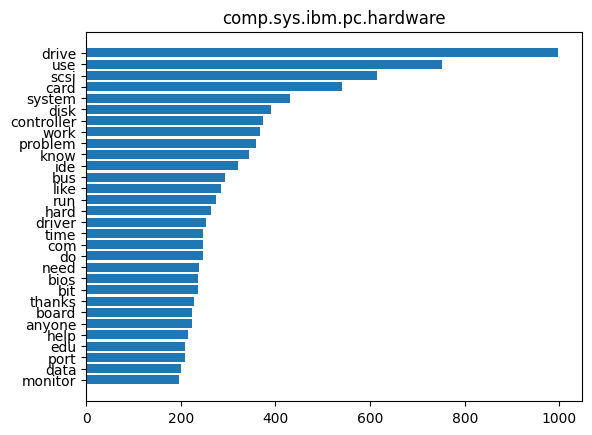

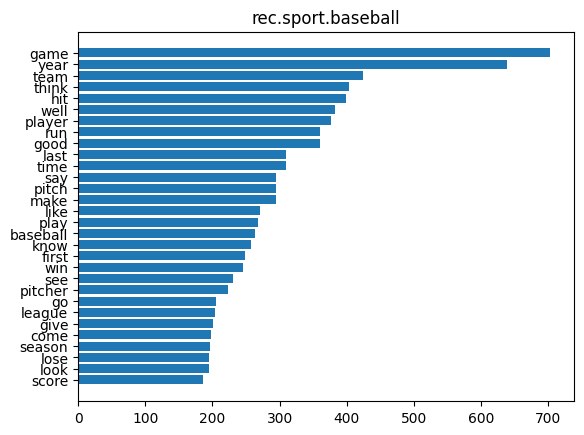

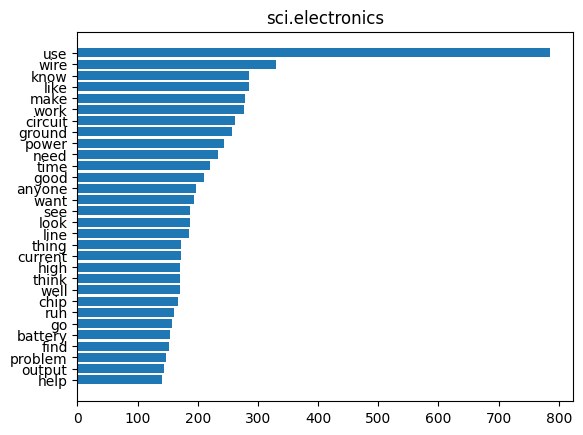

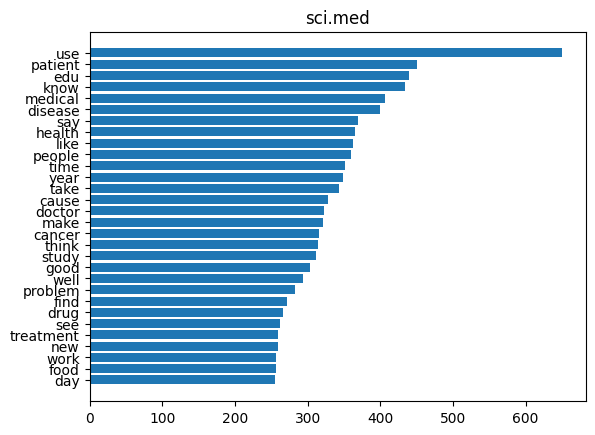

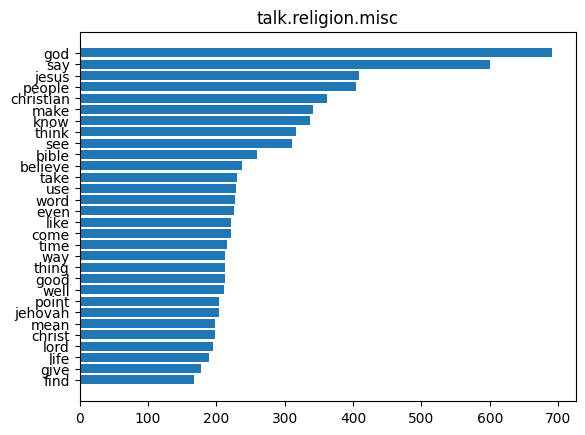

In [20]:
# We display the most common 30 words for each label. We observe that a strong semantic association emmerges between the label of each newsgroup and the most common words.
for label_index in range(number_of_unique_labels):
    label = unique_labels[label_index]
    
    df_single = df[df['label'].isin({label})]
    count = Counter(w for x in df_single['text'] for w in x.split())
    most_commons = count.most_common(30)

    plt.figure()
    plt.barh(*zip(*most_commons));
    plt.gca().invert_yaxis()
    plt.title(label)

In [21]:
# Alternative representation of the most common words, for the label 'rec.sport.hockey' 
wordcloud = WordCloud(background_color="white", max_words=1000, random_state = random_seed, width=1600, height=1200)
df_hockey = df[df['label'].isin({'rec.sport.hockey'})]
df_hockey = df_hockey.text.tolist()
df_hockey = ' '.join(df_hockey)
wordcloud.generate(df_hockey)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [22]:
vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform(df['text'])
print(embeddings.shape)

(4578, 27296)


### Principal Components Analysis

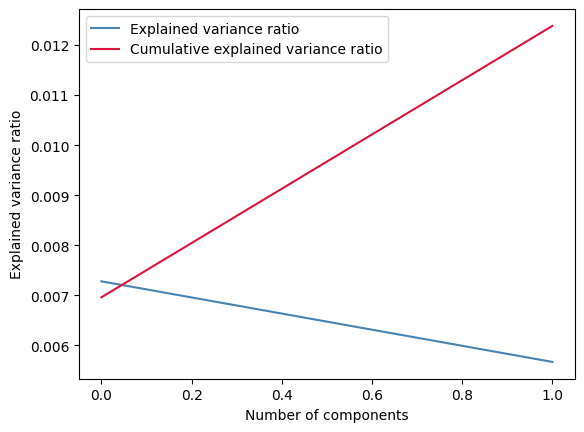

In [33]:

pca = PCA(n_components=2, random_state=random_seed)
X_new = pca.fit_transform(embeddings)

plt.figure()
plt.plot(pca.explained_variance_ratio_, color='steelblue', label='Explained variance ratio')
plt.plot(pca.explained_variance_ratio_.cumsum(), color='crimson', label='Cumulative explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.legend()
plt.show()

In [29]:
print(X_new.shape)

(4578, 2)


0: comp.sys.ibm.pc.hardware
1: rec.sport.baseball
2: sci.electronics
3: sci.med
4: talk.religion.misc


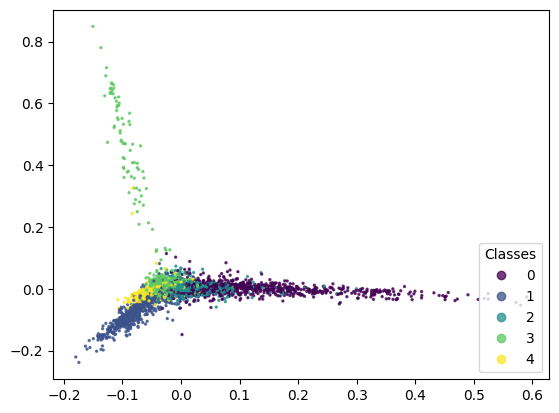

In [30]:
plt.figure()
scatter = plt.scatter(X_new[:,0], X_new[:,1], c=df['label_indices'], alpha=0.75, s=2)
u = np.unique(df['label_indices'])
plt.legend(scatter.legend_elements()[0], u, loc='lower right', title='Classes')

for label_index in range(number_of_unique_labels):
    print('{}: {}'.format(label_index, unique_labels[label_index]))

# k-means

In [ ]:
km = KMeans(n_clusters=number_of_unique_labels, init='k-means++', max_iter=100)
km.fit(embeddings)


centroids = km.cluster_centers_.argsort()[:,::-1] 
terms = vectorizer.get_feature_names_out()
for cluster_index in range(number_of_unique_labels):
    print('Cluster {}'.format(cluster_index))
    for centroid_index in centroids[cluster_index, :10]:
        print(' %s' % terms[centroid_index], end='')
    print()



